# Explore potentially-misplaced content

## Context

This notebook is for exploring how to identify content in the 'wrong' taxon. For example, the content could be entirely unrelaed to the taxon it's been tagged to, or ther might be a more granular taxon that it's better suited to.

## Prepare workspace

Assuming for now that your working directory is at `/content-similarity-models/google-universal-encoder`

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import pairwise_distances, pairwise_distances_chunked

import altair as alt
from altair import datum
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Read and prepare data

There are a few data sets used here:

1. Content items and embeddings
    1. Labelled data (data frame with a row per content item)
    1. Embedded sentences (an array of the pairwise cosine similarity scores)
1. Taxon homogeneity scores

### 1A. Labelled data (DataFrame)

The 'labelled' dataset is a pre-prepared DataFrame where each row is a content item. Variables are metadata about that content item, like its content ID number, or features of that item, like the title and body text. It's 'labelled' in the sense that it has taxon information included.

In [3]:
labelled = pd.read_csv(
    '../data/2019-02-11/labelled.csv.gz',
    compression = 'gzip',
    low_memory = False
)

In [4]:
labelled.iloc[1]

base_path                          /government/news/charity-commission-names-furt...
content_id                                      5fa49c52-7631-11e4-a3cb-005056011aef
description                            regulator increases transparency of its work.
document_type                                                          press_release
first_published_at                                     2014-06-04T23:00:00.000+00:00
locale                                                                            en
primary_publishing_organisation                               The Charity Commission
publishing_app                                                             whitehall
title                              charity commission names further charities und...
body                               the charity commission has today named further...
combined_text                      charity commission names further charities und...
taxon_id                                        668cd623-c7a8-415

Each content item can exist in more than one row; it might be tagged to more than one part of the taxonomy.

In [5]:
labelled.shape  # 306k rows

(305703, 19)

In [6]:
labelled.drop_duplicates('content_id').shape  # 208k rows when duplicates removed

(208261, 19)

Prep object containing relationship between `taxon_id` and `taxon_name`.

In [7]:
taxon_id_name = labelled[['taxon_id', 'taxon_name', 'level1taxon', 'level2taxon', 'level3taxon', 'level4taxon', 'level5taxon']].drop_duplicates()

### 1B. Embedded sentences (numpy array)

A numpy array of embeddings for content items. The index matches that of 'labelled'.

In [8]:
embedded_sentences = np.load('../data/embedded_sentences2019-02-11.npy')

In [9]:
embedded_sentences[:2]

array([[ 0.05357241,  0.00247775, -0.020976  , ..., -0.05675139,
         0.01268296,  0.01008949],
       [-0.04339019, -0.03241241,  0.00900179, ..., -0.04839829,
         0.03903588, -0.0553612 ]], dtype=float32)

### 2. Taxon homogeneity scores

This is a Pandas DataFrame generated by the `get_homogeneity_scores_taxon.py` script. Each row is a taxon with some descriptive variables like the mean cosine score of all contained content items.

In [10]:
taxon_homogeneity_df = pd.read_csv("../data/taxon_homogeneity_df.csv")

In [11]:
taxon_homogeneity_df.shape

(1265, 9)

In [12]:
taxon_homogeneity_df.iloc[1]

Unnamed: 0                                                        246
taxon_id                         f9e476ef-654d-41ec-97d9-2b6842d4361d
taxon_size                                                        786
mean_cosine_score                                            0.589025
taxon_base_path               /society-and-culture/sports-and-leisure
taxon_level                                                         2
level1taxon                                       Society and culture
fewer_than_or_equal_5items                                          0
more_than_0_5_diversity                                             1
Name: 1, dtype: object

# Explore misplaced content

At two levels:

1. High-level structure (can we spot taxons that might contain problem content using taxon-level metrics?)
1. Identify problem content within taxons (can we identify and extract problem content from a given taxon?)

## 1. High-level structure

### Cosine similarity vs taxon size

Plot mean cosine similarity against taxon size; coloured by depth.

In [13]:
numcols = 6  # specify the number of columns you want
level1taxons = taxon_homogeneity_df['level1taxon'].unique() 

money = taxon_homogeneity_df[taxon_homogeneity_df.level1taxon == 'Money'].copy()

total_size = money['taxon_size'].sum().astype(str)

money_plot = alt.Chart(money).mark_circle(size=60).encode(
    alt.X(
        'taxon_size:Q',
        scale=alt.Scale(type='log', domain=(1, 10000)),
        axis=alt.Axis(grid=False, title='log(topic_size)')
    ),
    alt.Y(
        'mean_cosine_score:Q',
        scale=alt.Scale(domain=(0, 0.6)),
        axis=alt.Axis(grid=False, title='content diversity score')
    ), 
    color=alt.Color('taxon_level:N', scale=alt.Scale(scheme='magma')),
    opacity=alt.value(0.8), 
    tooltip=['taxon_base_path']
).properties(
        title='Money' + ", " + total_size).interactive()

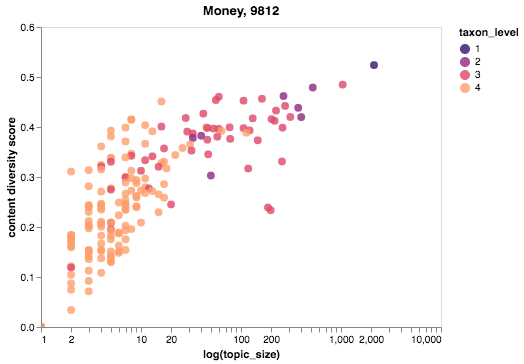

In [14]:
money_plot.display()

In [15]:
# Save the chart
# money_plot.save('money.html', scale_factor=2.0)

Are there any level 2 taxons within the money branch that have poor mean cosine similarity?

In [16]:
th = taxon_homogeneity_df  # simplify name of DataFrame for easier handling

th[(th.taxon_level == 2) & (th.level1taxon == 'Money')& (th.taxon_size < 300) & (th.mean_cosine_score > 0.5)]

,Unnamed: 0,taxon_id,taxon_size,mean_cosine_score,taxon_base_path,taxon_level,level1taxon,fewer_than_or_equal_5items,more_than_0_5_diversity


None of the level 2 taxons exceed a homogeneity score of 0.5. What are the top 5 by highest mean cosine score?

In [17]:
money_level2 = th[(th.level1taxon == 'Money') & (th.taxon_level == 2)].sort_values('mean_cosine_score', ascending=False)
money_level2.iloc[:4]

,Unnamed: 0,taxon_id,taxon_size,mean_cosine_score,taxon_base_path,taxon_level,level1taxon,fewer_than_or_equal_5items,more_than_0_5_diversity
85,41,28262ae3-599c-4259-ae30-3c83a5ec02a1,522,0.478880,/money/business-tax,2,Money,0,0
125,377,b20215a9-25fb-4fa6-80a3-42e23f5352c2,266,0.461853,/money/dealing-with-hmrc,2,Money,0,0
215,194,35136812-221c-4ba2-8ed1-46e409ca5e10,373,0.438402,/money/tax-evasion-and-avoidance,2,Money,0,0
297,42,a5c88a77-03ba-4100-bd33-7ee2ce602dc8,400,0.419783,/money/personal-tax,2,Money,0,0


## 2. Identify problem content within taxons
Content may have been tagged in the wrong place. How can we identify this? One idea is to look at the cosine similarity between each content item and all the others within a taxon and then inspect the ones with scores that are above a certain threshold (i.e. they're semantically different to everything else).

Sections below:

A. Example: business tax taxon  
B. Function to get misplaced content  
C. Get all potentially-misplaced contents from level 2 money taxons

### A. Example: 'business tax' taxon
This section contains a manual test of extracting misplaced content based on mean cosine similarity with other content in the taxon. This is generalised in a function in the section below.

Store the taxon ID as a variable.

In [18]:
btax_id = '28262ae3-599c-4259-ae30-3c83a5ec02a1'

Filter the embedded sentences (a numpy array) where it matches the business tax taxon ID. Indices for `embedded sentences` and `labelled` are the same, so `labelled` can be used to help filter.

In [19]:
btax_embedded = embedded_sentences[labelled['taxon_id'] == btax_id]

Get the cosine similarity for all content item pairs in the taxon, convert to a Pandas DataFrame and then get the mean distances for each content item.

In [20]:
# Array
btax_dist = pairwise_distances(
    btax_embedded, 
    metric = 'cosine', 
    n_jobs = -1
)

# To DataFrame
btax_dist_df = pd.DataFrame(btax_dist)  

# Add column for mean distance
btax_dist_df['mean'] = btax_dist.mean(axis = 1)

In [21]:
btax_dist_df.shape  # a matrix of all taxons versus all taxons

(522, 523)

How many content items (rows) have a larger mean distance than the overall mean?

In [22]:
btax_dist_df[btax_dist_df['mean'] > btax_dist.mean()].shape

(212, 523)

Now we can use this information to filter the data frame of labelled content items (`labelled`), leaving us with a data frame of the problem content.

We can start by filtering the `labelled` data so we have only the content items that are in the business tax taxon.

In [23]:
btax_content = labelled[labelled['taxon_id'] == btax_id].reset_index()

In [24]:
btax_content.shape

(522, 20)

Now return content items from the data frame where the mean cosine similarity score is above a threshold value. These are the problem content items. Simplify the output to three columns of interest.

In [25]:
btax_misplaced = btax_content[['content_id', 'base_path', 'title', 'description']][btax_dist_df['mean'] > 0.65]
btax_misplaced.shape

(11, 4)

#### Which of these are algo-tagged vs human-tagged?

In [26]:
tag_origin = pd.read_csv('../data/bulk_and_algorithm_tags.tsv', sep = '\t')

In [27]:
tag_origin.head()

,content_id,taxon_tag,taxon_id,how_tagged
0,a113dedd-4320-4186-b1af-888437c6aedb,Environment,71d37f3a-7c8c-4128-8763-2fd5b831b9b9,bulk_tag
1,5d8d7f5f-7631-11e4-a3cb-005056011aef,International aid and development,9fb30a53-70fb-4f1c-878b-0064b202d1ba,bulk_tag
2,5e2e074d-7631-11e4-a3cb-005056011aef,Health and social care,8124ead8-8ebc-4faf-88ad-dd5cbcc92ba8,bulk_tag
3,5f50cd4e-7631-11e4-a3cb-005056011aef,Maritime,4a9ab4d7-0d03-4c61-9e16-47787cbf53cd,bulk_tag
4,b60d9e65-dc51-4a5b-8fbc-b6b15652b6ba,World,91b8ef20-74e7-4552-880c-50e6d73c2ff9,bulk_tag


In [28]:
algo_human_tag = pd.merge(btax_misplaced, tag_origin, on = 'content_id', how = 'inner')
algo_human_tag.sample(n = 5)

,content_id,base_path,title,description,taxon_tag,taxon_id,how_tagged
0,f9e12f0e-bd0d-5361-8d26-bc83bfb34729,/hmrc-internal-manuals/vat-womens-sanitary-pro...,vat women’s sanitary products,guidance on the reduced rate for women's sanit...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1,algorithm_v2.0.0
3,e110d285-20e0-431e-a394-39edabb2b331,/guidance/air-passenger-duty-and-connected-fli...,air passenger duty and connected flights,check which flights to treat as connected for ...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1,algorithm_v2.0.0
4,eb031ebb-7078-4879-a124-33753c4ca0bd,/guidance/rates-and-allowances-for-air-passeng...,rates for air passenger duty,check which rates of air passenger duty you ne...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1,algorithm_v2.0.0
9,e36ebdbf-b8df-4dc8-beb5-beece2f7b7de,/government/collections/gwe-rwydo-a-sgamiau,gwe-rwydo a sgamiau,cyngor ar ddiogelwch gan gyllid a thollau em i...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1,algorithm_v2.0.0
1,6f019571-54be-4344-aede-cebd901c1fe5,/guidance/rates-and-allowances-for-air-passeng...,historic rates for air passenger duty,check which air passenger duty rates apply for...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1,algorithm_v2.0.0


### B. Function to get misplaced content

In [29]:
def get_misplaced_content (
    taxon_id = '28262ae3-599c-4259-ae30-3c83a5ec02a1',
    similarity_threshold = 0.65,  # seems a reasonable threshold
    embedded_sentences_data = embedded_sentences,
    labelled_data = labelled
):
    
    """Identify content items that seem out of place in a given taxon.
    The cosine-similarity score (CSS) for each content item is calculated.
    Content items are extracted if their mean score is above a particular threshold (default 0.65).
    """
    
    print('Processing taxon ID ', taxon_id)
    
    # Get embeddedings for the specified taxon ID
    taxon_embedded = embedded_sentences[labelled['taxon_id'] == taxon_id]
    
    # Get distances between all content item pairs
    taxon_dist = pairwise_distances(
        taxon_embedded,
        metric = 'cosine', 
        n_jobs = -1
    )
    
    # As dataframe
    taxon_dist_df = pd.DataFrame(taxon_dist)
    
    # Calculate a mean
    taxon_dist_df['mean'] = taxon_dist.mean(axis = 1)
    
    # Get the rows of the labelled data (content items) that match the taxon ID
    taxon_content = labelled[labelled['taxon_id'] == taxon_id].reset_index()
    
    # Content items that are above the similarity threshold
    misplaced = taxon_content[['content_id', 'base_path', 'title', 'description', 'taxon_name']][taxon_dist_df['mean'] > similarity_threshold]
    
    # Add column with content_id
    misplaced['taxon_id'] = taxon_id
    
    return misplaced;

In [30]:
get_misplaced_content(similarity_threshold = 0.65)

Processing taxon ID  28262ae3-599c-4259-ae30-3c83a5ec02a1


,content_id,base_path,title,description,taxon_name,taxon_id
57,f9e12f0e-bd0d-5361-8d26-bc83bfb34729,/hmrc-internal-manuals/vat-womens-sanitary-pro...,vat women’s sanitary products,guidance on the reduced rate for women's sanit...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
66,a211f181-1cc0-45c0-8bb6-0491eb67fc92,/guidance/changes-to-chief-commodity-codes-tar...,changes to chief commodity codes (tariff stop ...,find out the changes to commodity codes in the...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
196,6f019571-54be-4344-aede-cebd901c1fe5,/guidance/rates-and-allowances-for-air-passeng...,historic rates for air passenger duty,check which air passenger duty rates apply for...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
219,e110d285-20e0-431e-a394-39edabb2b331,/guidance/air-passenger-duty-and-connected-fli...,air passenger duty and connected flights,check which flights to treat as connected for ...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
256,eb031ebb-7078-4879-a124-33753c4ca0bd,/guidance/rates-and-allowances-for-air-passeng...,rates for air passenger duty,check which rates of air passenger duty you ne...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
278,5f60a446-f47c-403a-aab3-bd83db20cf4f,/guidance/poultry-from-iceland-tariff-quota-no...,poultry from iceland (tariff quota notice 73),check the new tariff quota for poultry from ic...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
343,6eb3a99b-9a0b-464a-bb42-c08882c7d857,/government/publications/iso-country-codes,iso country codes,find out the iso country codes.,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
397,5d5afda3-7631-11e4-a3cb-005056011aef,/government/news/government-to-waive-vat-on-mi...,government to waive vat on military wives’ cha...,chancellor of the exchequer has today announce...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
430,0fea02ed-c1c8-4502-a7a2-f0ebebe1ee1c,/guidance/laser-skin-treatment-and-hair-remova...,laser skin treatment and hair removal (tariff ...,check the tariff classification of electrical ...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
478,e36ebdbf-b8df-4dc8-beb5-beece2f7b7de,/government/collections/gwe-rwydo-a-sgamiau,gwe-rwydo a sgamiau,cyngor ar ddiogelwch gan gyllid a thollau em i...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1


### C. Get all potentially-misplaced contents from level 2 money taxons

Get the `taxon_id`s for all level 2 taxons from the money branch to iterate over.

In [31]:
level2_money_taxonid = list(money_level2['taxon_id'])
level2_money_taxonid

['28262ae3-599c-4259-ae30-3c83a5ec02a1',
 'b20215a9-25fb-4fa6-80a3-42e23f5352c2',
 '35136812-221c-4ba2-8ed1-46e409ca5e10',
 'a5c88a77-03ba-4100-bd33-7ee2ce602dc8',
 '7c4cf197-2dba-4a82-83e2-6c8bb332525c',
 'a7b67f4f-1234-4a0c-90ba-eeed4c5183cd',
 '5605545e-03ca-4520-9519-163ea341bc86']

Loop over the `taxon_id`s using the `get_misplaced_content()` function to find misplaced items.

In [32]:
misplaced_items = []
for x in level2_money_taxonid:
  data = get_misplaced_content(taxon_id = x)
  misplaced_items.append(data)

Processing taxon ID  28262ae3-599c-4259-ae30-3c83a5ec02a1
Processing taxon ID  b20215a9-25fb-4fa6-80a3-42e23f5352c2
Processing taxon ID  35136812-221c-4ba2-8ed1-46e409ca5e10
Processing taxon ID  a5c88a77-03ba-4100-bd33-7ee2ce602dc8
Processing taxon ID  7c4cf197-2dba-4a82-83e2-6c8bb332525c
Processing taxon ID  a7b67f4f-1234-4a0c-90ba-eeed4c5183cd
Processing taxon ID  5605545e-03ca-4520-9519-163ea341bc86


Concatenate list output to DataFrame format.

In [33]:
misplaced_items = pd.concat(misplaced_items)

In [34]:
# Save the output
# misplaced_items.to_csv("~/Desktop/money_level2_misplaced.csv")

In [35]:
misplaced_items.iloc[:3]

,content_id,base_path,title,description,taxon_name,taxon_id
57,f9e12f0e-bd0d-5361-8d26-bc83bfb34729,/hmrc-internal-manuals/vat-womens-sanitary-pro...,vat women’s sanitary products,guidance on the reduced rate for women's sanit...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
66,a211f181-1cc0-45c0-8bb6-0491eb67fc92,/guidance/changes-to-chief-commodity-codes-tar...,changes to chief commodity codes (tariff stop ...,find out the changes to commodity codes in the...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1
196,6f019571-54be-4344-aede-cebd901c1fe5,/guidance/rates-and-allowances-for-air-passeng...,historic rates for air passenger duty,check which air passenger duty rates apply for...,Business tax,28262ae3-599c-4259-ae30-3c83a5ec02a1


#### Try other mean cosine thresholds

Try it with thresholds of 0.6 and 0.7 for mean cosine similarity score (default was 0.65).

In [36]:
misplaced_items_06 = []
for x in level2_money_taxonid:
  data = get_misplaced_content(taxon_id = x, similarity_threshold = 0.6)
  misplaced_items_06.append(data)
    
misplaced_items_06 = pd.concat(misplaced_items_06)

Processing taxon ID  28262ae3-599c-4259-ae30-3c83a5ec02a1
Processing taxon ID  b20215a9-25fb-4fa6-80a3-42e23f5352c2
Processing taxon ID  35136812-221c-4ba2-8ed1-46e409ca5e10
Processing taxon ID  a5c88a77-03ba-4100-bd33-7ee2ce602dc8
Processing taxon ID  7c4cf197-2dba-4a82-83e2-6c8bb332525c
Processing taxon ID  a7b67f4f-1234-4a0c-90ba-eeed4c5183cd
Processing taxon ID  5605545e-03ca-4520-9519-163ea341bc86


In [37]:
misplaced_items_07 = []
for x in level2_money_taxonid:
  data = get_misplaced_content(taxon_id = x, similarity_threshold = 0.7)
  misplaced_items_07.append(data)

misplaced_items_07 = pd.concat(misplaced_items_07)

Processing taxon ID  28262ae3-599c-4259-ae30-3c83a5ec02a1
Processing taxon ID  b20215a9-25fb-4fa6-80a3-42e23f5352c2
Processing taxon ID  35136812-221c-4ba2-8ed1-46e409ca5e10
Processing taxon ID  a5c88a77-03ba-4100-bd33-7ee2ce602dc8
Processing taxon ID  7c4cf197-2dba-4a82-83e2-6c8bb332525c
Processing taxon ID  a7b67f4f-1234-4a0c-90ba-eeed4c5183cd
Processing taxon ID  5605545e-03ca-4520-9519-163ea341bc86


In [38]:
# Save outputs
# misplaced_items_06.to_csv('misplaced_items_06.csv')
# misplaced_items_07.to_csv('misplaced_items_07.csv')

#### What other tags do the misplaced items have?

Rename and reorder columns in misplaced items dataframe. Rename to identify the taxons as the problematic ones within which the given content item has been flagged as misplaced; this is helpful when merging with the other tags.

In [39]:
misplaced_items = misplaced_items.rename(columns={
    'taxon_name': 'misplaced_taxon_name',
    'taxon_id': 'misplaced_taxon_id',
    'base_path': 'misplaced_base_path'
}
)

misplaced_items = misplaced_items[[
    'content_id', 'title', 'description',
    'misplaced_taxon_id', 'misplaced_taxon_name', 'misplaced_base_path'
]]

misplaced_items.head()

,content_id,title,description,misplaced_taxon_id,misplaced_taxon_name,misplaced_base_path
57,f9e12f0e-bd0d-5361-8d26-bc83bfb34729,vat women’s sanitary products,guidance on the reduced rate for women's sanit...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/hmrc-internal-manuals/vat-womens-sanitary-pro...
66,a211f181-1cc0-45c0-8bb6-0491eb67fc92,changes to chief commodity codes (tariff stop ...,find out the changes to commodity codes in the...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/changes-to-chief-commodity-codes-tar...
196,6f019571-54be-4344-aede-cebd901c1fe5,historic rates for air passenger duty,check which air passenger duty rates apply for...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/rates-and-allowances-for-air-passeng...
219,e110d285-20e0-431e-a394-39edabb2b331,air passenger duty and connected flights,check which flights to treat as connected for ...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/air-passenger-duty-and-connected-fli...
256,eb031ebb-7078-4879-a124-33753c4ca0bd,rates for air passenger duty,check which rates of air passenger duty you ne...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/rates-and-allowances-for-air-passeng...


Dataframe where each row is a content item/taxon tag pair. Simplify so it can be merged into our dataframe of misplaced content.

In [40]:
content_id_name = labelled[['content_id', 'taxon_id', 'taxon_name']]

content_id_name = content_id_name.rename(columns = {
    'taxon_id': 'other_taxon_id',
    'taxon_name': 'other_taxon_name'
}
)

content_id_name.sort_values('content_id').head()

,content_id,other_taxon_id,other_taxon_name
176658,0000d0a0-037a-4110-a271-24327f422d06,80cb30f4-0361-49ea-ad84-bc10910318bf,Charities and social enterprises
2871,0000d0a0-037a-4110-a271-24327f422d06,668cd623-c7a8-4159-9575-90caac36d4b4,Community and society
232284,00012147-49f6-4e90-be1f-e50bb719f53d,d949275c-88f8-4623-a44b-eb3706651e10,Intellectual property
65198,0001f1a9-3285-4897-baa9-f6663aeb1e8a,f3f4b5d3-49c4-487b-bd5b-be75f11ec8c5,"Government efficiency, transparency and accoun..."
74041,00021930-c266-4312-aeaa-96813c1d8860,3cf97f69-84de-41ae-bc7b-7e2cc238fa58,Environment


Merge and remove redundant rows where misplaced taxon name and other taxon name are the same.

In [41]:
misplaced_content_tags = pd.merge(misplaced_items, content_id_name, on = 'content_id', how = 'left')

misplaced_content_tags = misplaced_content_tags[
    (misplaced_content_tags.misplaced_taxon_name != misplaced_content_tags.other_taxon_name)
]

misplaced_content_tags.head()

,content_id,title,description,misplaced_taxon_id,misplaced_taxon_name,misplaced_base_path,other_taxon_id,other_taxon_name
2,a211f181-1cc0-45c0-8bb6-0491eb67fc92,changes to chief commodity codes (tariff stop ...,find out the changes to commodity codes in the...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/changes-to-chief-commodity-codes-tar...,277fd1ce-61c3-46a4-9172-3101fda02111,UK Trade Tariff and classification of goods
3,a211f181-1cc0-45c0-8bb6-0491eb67fc92,changes to chief commodity codes (tariff stop ...,find out the changes to commodity codes in the...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/changes-to-chief-commodity-codes-tar...,1da20ae5-526d-4313-b93d-fed4491f8ed8,Commodity codes and reporting
5,6f019571-54be-4344-aede-cebd901c1fe5,historic rates for air passenger duty,check which air passenger duty rates apply for...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/rates-and-allowances-for-air-passeng...,60677783-056b-484d-89cf-f22a12d1980a,Air passenger duty
7,e110d285-20e0-431e-a394-39edabb2b331,air passenger duty and connected flights,check which flights to treat as connected for ...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/air-passenger-duty-and-connected-fli...,60677783-056b-484d-89cf-f22a12d1980a,Air passenger duty
9,eb031ebb-7078-4879-a124-33753c4ca0bd,rates for air passenger duty,check which rates of air passenger duty you ne...,28262ae3-599c-4259-ae30-3c83a5ec02a1,Business tax,/guidance/rates-and-allowances-for-air-passeng...,b20215a9-25fb-4fa6-80a3-42e23f5352c2,Dealing with HMRC


In [42]:
# Save output
# misplaced_content_tags.to_csv('misplaced_content_tags.csv')

### Misplaced items in Brexit taxon

Get cosine similarity to look for potentially-misplaced content within entirety of brexit taxon (ignores that there's a couple of child taxons).

In [44]:
# Isolate Brexit taxons
brexit_taxons = taxon_id_name[(taxon_id_name.level2taxon == 'Brexit')]

In [46]:
# There's two: Brexit itself, plus a single child
level2_brexit_taxonid = list(brexit_taxons['taxon_id'])
level2_brexit_taxonid

['d6c2de5d-ef90-45d1-82d4-5f2438369eea',
 'd7bdaee2-8ea5-460e-b00d-6e9382eb6b61']

Run the function over Brexit content

In [47]:
misplaced_brexit = []
for x in level2_brexit_taxonid:
  data = get_misplaced_content(taxon_id = x)
  misplaced_brexit.append(data)

Processing taxon ID  d6c2de5d-ef90-45d1-82d4-5f2438369eea
Processing taxon ID  d7bdaee2-8ea5-460e-b00d-6e9382eb6b61


In [48]:
misplaced_brexit = pd.concat(misplaced_brexit)
misplaced_brexit.head()

,content_id,base_path,title,description,taxon_name,taxon_id
131,01f35ddf-53b8-4d2a-806b-d103fc67a2ab,/government/speeches/mi6-c-speech-on-fourth-ge...,mi6 'c' speech on fourth generation espionage,mi6 chief alex younger spoke on how the secret...,Brexit,d6c2de5d-ef90-45d1-82d4-5f2438369eea
162,5e29eb5a-ff5d-45ce-bfaf-0e36c78994f7,/government/publications/attorney-generals-let...,attorney general's letter to speaker,the attorney general's letter regarding the mo...,Brexit,d6c2de5d-ef90-45d1-82d4-5f2438369eea
314,515dde37-4338-4158-9055-acc340b94370,/government/publications/how-the-department-fo...,how the department for exiting the european un...,hr and finance personal information,Brexit,d6c2de5d-ef90-45d1-82d4-5f2438369eea
317,59da38b4-0836-4451-908c-23204be76be1,/government/publications/renal-cancer-and-occu...,renal cancer and occupational exposure to tric...,this is the council’s note about renal cancer ...,Brexit,d6c2de5d-ef90-45d1-82d4-5f2438369eea
378,5c7215de-7631-11e4-a3cb-005056011aef,/guidance/the-marketing-of-agricultural-and-ve...,apply to have seeds certified for marketing,the seeds which must be certified before you c...,Brexit,d6c2de5d-ef90-45d1-82d4-5f2438369eea


In [ ]:
# Save output
# misplaced_brexit.to_csv("misplaced_brexit.csv")